# Group Project(2)

***MEIN40330 - AI for Personalised Medicine - 2024/25 Summer***

> - **Programmer:** Yu Du
> - **Last Update:** Aug. 4<sup>th</sup>, 2025

**Keywords:** **Lung Cancer**, **LINC**, **Targets**

In this final group project assignment, we selected lung cancer as our research focus. In this assignment, I primarily used two datasets — [*DepMap*](https://depmap.org/portal/data_page/?tab=allData) and [*CMAP LINCS 2020*](https://clue.io/data/CMap2020#LINCS2020) — to address Question 4 based on the requirement. The datasets used for this question are as follows:

- **CRISPRGeneEffect.csv** -- *Gene effect scores from CRISPR knockout screens across all cancer cell lines. Lower scores (e.g., < -0.5) indicate stronger dependence on the gene for cell viability.*
- **CRISPRGeneDependency.csv** -- *Dependency probability estimates (0 to 1) from CRISPR screens for each gene-cell line pair. Values closer to 1 suggest essentiality of the gene in that context.*
- **Achilles_gene_effect.csv** -- *Gene effect scores from RNAi knockdown experiments (Achilles project). Similar interpretation to CRISPRGeneEffect but based on RNA interference.*
- **Model.csv** -- *Metadata for all DepMap cell lines, including identifiers, tissue of origin, primary disease, subtype, etc.*

- **instinfo_beta.txt** -- *Metadata for each experiment instance (i.e., drug perturbation): includes dose, time, cell line, QC metrics, and associated compound ID (`pert_id`).*
- **siginfo_beta.txt** -- *Signature-level metadata (collapsed results across replicates): includes `sig_id`, TAS score, compound name, and whether the signature passed quality control.*
- **compoundinfo_beta.txt** -- *Compound-level annotations: includes LINCS internal `broad_id`, compound name (`cmap_name`), mechanism of action (MOA), and known targets.*
- **level5_beta_trt_cp_n720216x12328.gctx** -- *Gene expression Z-score matrix for over 1 million compound perturbation signatures (level 5, consensus signatures) across ~12,000 genes.*
- **geneinfo_beta.txt** -- *Probe-to-gene mapping for L1000 platform: links numeric probe IDs (`gene_id`) in `.gctx` to gene symbols.*
- **LINCS2020 Release Metadata Field Definitions.xlsx** -- *Official field descriptions for all columns used in LINCS metadata files. Provides definitions and value types for files like `siginfo`, `instinfo`, etc.*

Additionally, I have stored the raw datasets, intermediate files, and final results on [my Google Drive](https://drive.google.com/drive/folders/1_QTRhetat6W3v4sGcQLascEiugoGqZ3a?usp=sharing) for reference.

The required runtime environment can be set up using the following commands:
```bash
conda create -n afpm-lab-env python=3.10 -y
conda activate afpm-lab-env
pip install numpy pandas matplotlib cmapPy
```

In [1]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt

from cmapPy.pandasGEXpress.parse import parse

---

## Question 4: Can you suggest potential new drug targets using LINCS data? Or based on DepMap data? Or both? 

In [2]:
# ========= Data Loading =========
# Read gene-dependent data (CRISPR & RNAi)
crispr_effect = pd.read_csv("./CRISPRGeneEffect.csv", index_col=0)
crispr_dependency = pd.read_csv("./CRISPRGeneDependency.csv", index_col=0)
achilles_effect = pd.read_csv("./Achilles_gene_effect.csv", index_col=0)

# Read lung cancer cell line information (Model.csv)
model_info = pd.read_csv("./Model.csv")

# Read LINCS drug signature data
compound_info = pd.read_csv("./compoundinfo_beta.txt", sep="\t", low_memory=False)
instinfo = pd.read_csv("./instinfo_beta.txt", sep="\t", low_memory=False)
siginfo = pd.read_csv("./siginfo_beta.txt", sep="\t", low_memory=False)

# Read GCTX Files
gctoo = parse("./level5_beta_trt_cp_n720216x12328.gctx")

# Read geneinfo file to build mapping table
geneinfo = pd.read_csv("./geneinfo_beta.txt", sep="\t")

/opt/miniconda3/envs/afpm-lab-env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/opt/miniconda3/envs/afpm-lab-env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


In [ ]:
# ========= DepMap — CRISPR and RNAi Dependency Analysis =========
# Filter lung cancer cell lines
lung_models = model_info[model_info["OncotreePrimaryDisease"].str.contains("lung", case=False, na=False)]["ModelID"]

# CRISPR gene effect scores
lung_crispr_effect = crispr_effect.loc[crispr_effect.index.intersection(lung_models)]
mean_crispr = lung_crispr_effect.mean(axis=0).sort_values()
top_crispr_targets = mean_crispr[mean_crispr < -0.5].head(50)

# CRISPR gene dependency probability
lung_crispr_dep = crispr_dependency.loc[crispr_dependency.index.intersection(lung_models)]
mean_dep_prob = lung_crispr_dep.mean(axis=0).sort_values(ascending=False)
top_dep_prob = mean_dep_prob[mean_dep_prob > 0.5].head(50)

# Achilles RNAi effect scores
lung_achilles = achilles_effect.loc[achilles_effect.index.intersection(lung_models)]
mean_achilles = lung_achilles.mean(axis=0).sort_values()
top_achilles_targets = mean_achilles[mean_achilles < -0.5].head(50)

# Combine consistent top dependency genes
common_targets = set(top_crispr_targets.index) & set(top_achilles_targets.index) & set(top_dep_prob.index)
print("Consistent CRISPR and RNAi critical genes in lung cancer:")
print(common_targets)

Consistent CRISPR and RNAi critical genes in lung cancer:
{'RPS20 (6224)', 'PCNA (5111)', 'HSPE1 (3336)', 'PSMA6 (5687)', 'PSMA3 (5684)', 'PSMB3 (5691)', 'RPL23 (9349)', 'RAN (5901)', 'RPL17 (6139)'}


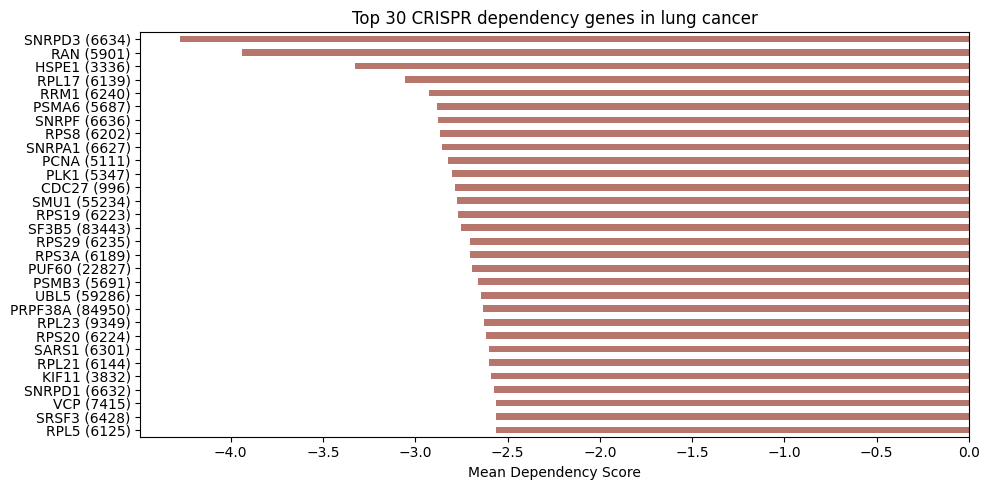

In [5]:
# Visualization
plt.figure(figsize=(10, 5))
top_crispr_targets.head(30).plot(kind='barh', color='#B6766C')
plt.gca().invert_yaxis()
plt.title("Top 30 CRISPR dependency genes in lung cancer")
plt.xlabel("Mean Dependency Score")
plt.tight_layout()
plt.show()

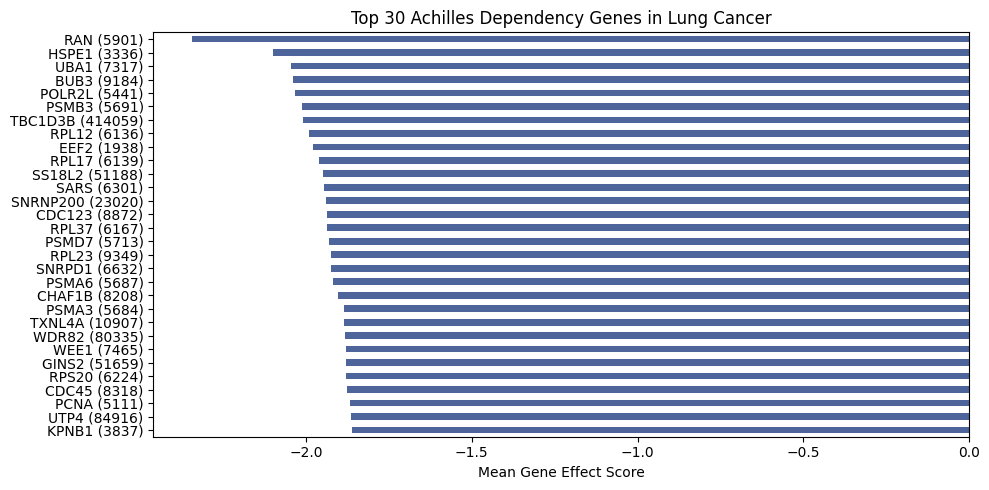

In [6]:
# Visualization
plt.figure(figsize=(10, 5))
top_achilles_targets.head(30).plot(kind='barh', color='#4E659B')
plt.gca().invert_yaxis()
plt.title("Top 30 Achilles Dependency Genes in Lung Cancer")
plt.xlabel("Mean Gene Effect Score")
plt.tight_layout()
plt.show()

In [7]:
# Normalization: map each score to the range 0-1
norm_crispr = (mean_crispr - mean_crispr.min()) / (mean_crispr.max() - mean_crispr.min())
norm_achilles = (mean_achilles - mean_achilles.min()) / (mean_achilles.max() - mean_achilles.min())
norm_dep = 1 - ((mean_dep_prob - mean_dep_prob.min()) / (mean_dep_prob.max() - mean_dep_prob.min()))

# Simple weighted average (the smaller the value, the more critical)
combined_score = (norm_crispr + norm_achilles + norm_dep) / 3
final_top_genes = combined_score.sort_values().head(50)
print("Top integrated dependency genes:")
print(final_top_genes)

Top integrated dependency genes:
RAN (5901)          0.023394
HSPE1 (3336)        0.092060
RPL17 (6139)        0.126085
SNRPD3 (6634)       0.128411
PSMA6 (5687)        0.142459
PSMB3 (5691)        0.147630
PCNA (5111)         0.152328
SNRPF (6636)        0.158674
RPL23 (9349)        0.159232
RRM1 (6240)         0.161965
SNRPD1 (6632)       0.163443
POLR2L (5441)       0.164405
RPS20 (6224)        0.165144
RPL12 (6136)        0.166489
SMU1 (55234)        0.166739
SNRPA1 (6627)       0.168291
KIF11 (3832)        0.169722
PSMA3 (5684)        0.169947
WEE1 (7465)         0.174571
PLK1 (5347)         0.176592
EEF2 (1938)         0.177148
FAU (2197)          0.181505
RPS11 (6205)        0.182059
SNRNP200 (23020)    0.183128
VCP (7415)          0.184450
PSMA1 (5682)        0.185045
SF3B5 (83443)       0.185546
RPS29 (6235)        0.185762
BUB3 (9184)         0.186841
ANKLE2 (23141)      0.188142
LSM2 (57819)        0.190067
PRPF19 (27339)      0.190330
PUF60 (22827)       0.190354
CDC45 (831

In [ ]:
# ========= LINCS Analysis — Find Drugs with Strong Signatures in Lung Cancer (A549) =========
# Filter for A549 cell line and compound treatment
a549_signatures = siginfo[
    (siginfo["pert_type"] == "trt_cp") &
    (siginfo["cell_iname"].str.upper() == "A549") &
    (siginfo["qc_pass"] == 1)
]

# Join with instinfo to get TAS and quality info
merged = pd.merge(a549_signatures, instinfo, on=["pert_id"], suffixes=("", "_inst"))
top_drug_sigs = merged[merged["tas"] > 0.3].sort_values("tas", ascending=False)

# Get top 50 drugs (by TAS) in A549
top_drugs = top_drug_sigs.drop_duplicates("pert_id")[["cmap_name", "pert_id", "tas", "pert_dose", "pert_time"]]
print("Top 50 drug signatures in A549 (by TAS):")
print(top_drugs.head(50))

Top 50 drug signatures in A549 (by TAS):
                 cmap_name        pert_id       tas  pert_dose  pert_time
18821481          AZD-5438  BRD-K72414522  0.880236   10.00000       24.0
6005202              R-547  BRD-K52233191  0.880016   10.00000       24.0
1412616   5-iodotubercidin  BRD-A18497530  0.872905   10.00000       24.0
4187684          alvocidib  BRD-K87909389  0.870914   10.00000       24.0
18054062           AT-7519  BRD-K13390322  0.870615   10.00000       24.0
3663386         bortezomib  BRD-K88510285  0.864001   10.00000       24.0
17681854        dinaciclib  BRD-K13662825  0.861365   10.00000       24.0
18486220       resminostat  BRD-K28822270  0.858936   10.46260       24.0
18057287      daunorubicin  BRD-K91966436  0.855464   10.00000       48.0
19011180        dacinostat  BRD-K56957086  0.855253   10.00000       24.0
1807030            ouabain  BRD-A68930007  0.851282   10.00000       24.0
6032318       daunorubicin  BRD-A37630846  0.849049    1.00000       24

In [ ]:
# ========= Drug-Target Matching =========
# Match compoundinfo target fields to DepMap top genes
compound_info = compound_info[compound_info["target"].notna() & (compound_info["target"].str.strip() != "")]
common_target_genes = set(t.split(" ")[0] for t in final_top_genes.index)
compound_info["matches_top_gene"] = compound_info["target"].apply(
    lambda target_str: bool(common_target_genes.intersection(
        set(t.strip().upper() for t in target_str.split(",")))
    )
)

matched_compounds = compound_info[compound_info["matches_top_gene"]]
matched_compounds = matched_compounds[matched_compounds["pert_id"].isin(top_drugs["pert_id"])]

# Merge with top_drugs info
final_matches = pd.merge(matched_compounds, top_drugs, left_on="pert_id", right_on="pert_id")

print("Potential drug-target matches (LINCS drug targets ∩ DepMap essential genes):")
print(final_matches.head(10)[["cmap_name_x", "moa", "target", "tas", "pert_dose", "pert_time"]])

Potential drug-target matches (LINCS drug targets ∩ DepMap essential genes):
     cmap_name_x                      moa target       tas  pert_dose  \
0     epirubicin  Topoisomerase inhibitor  TOP2A  0.846695      10.00   
1      alvocidib            CDK inhibitor   CDK1  0.870914      10.00   
2        AT-7519            CDK inhibitor   CDK1  0.870615      10.00   
3  BRD-K71726959            CDK inhibitor   CDK1  0.592385     122.55   
4      CGP-60474            CDK inhibitor   CDK1  0.746398       0.37   
5     dinaciclib            CDK inhibitor   CDK1  0.861365      10.00   
6      indirubin            CDK inhibitor   CDK1  0.311850       1.00   
7      indirubin            CDK inhibitor   CDK1  0.314526      10.00   
8    JNJ-7706621            CDK inhibitor   CDK1  0.727247      10.00   
9    kenpaullone            CDK inhibitor   CDK1  0.560182       1.70   

   pert_time  
0       24.0  
1       24.0  
2       24.0  
3        6.0  
4       24.0  
5       24.0  
6       48.0  

In [ ]:
# ========= Gene Expression Signature Target Validation =========
expression_data = gctoo.data_df     # rows: rid, columns: sig_id

# Extract the top 50 drug signature sig_id (from siginfo)
top_50_sigs = top_drug_sigs.drop_duplicates("pert_id").head(50)
sig_ids = top_50_sigs["sig_id"].tolist()
expression_df = expression_data[sig_ids]

# Build mapping dictionary: key = rid(str), value = gene_symbol
rid_to_symbol = geneinfo.set_index("gene_id")["gene_symbol"].to_dict()

# Convert rid to gene_symbol (keep the part that can be mapped)
mapped_index = [rid_to_symbol.get(int(rid), None) for rid in expression_df.index]
expression_df.index = mapped_index

# Delete rows that cannot be mapped
expression_df = expression_df[~expression_df.index.isna()]
expression_df.index.name = "gene"

# Add the drug name
expression_df.columns = top_50_sigs["cmap_name"].values

# Save expression profile
expression_df.to_csv("./A549_top50_drug_expression_profiles.csv")

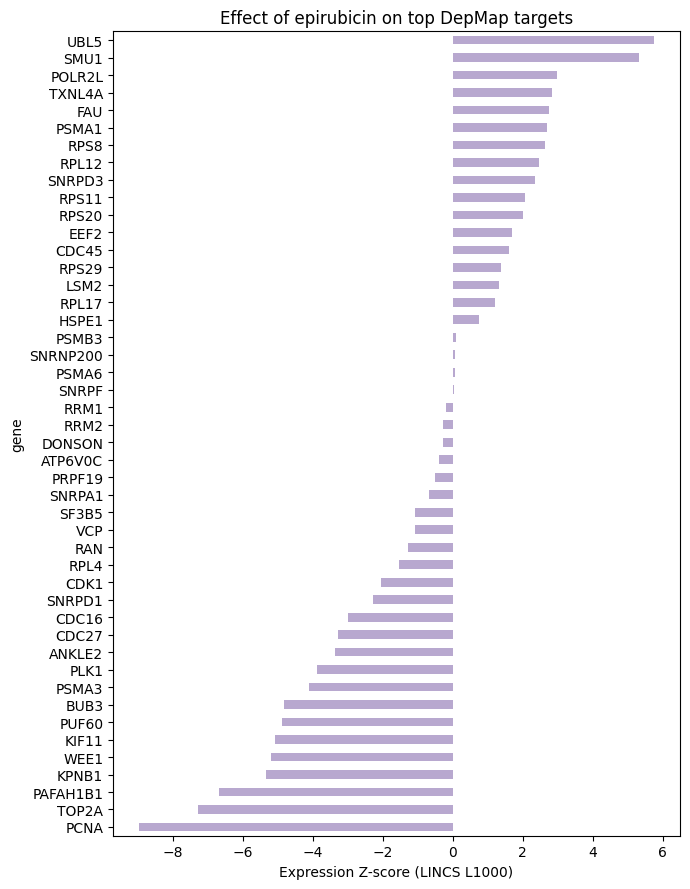

In [ ]:
# Extract the core target gene names obtained from DepMap analysis (remove brackets)
common_genes = [g.split(" ")[0] for g in final_top_genes.index]

# Find the intersection of these genes in expression_df
common_genes = list(set(common_genes) & set(expression_df.index))

# Extract the expression changes of these genes
effect_on_targets = expression_df.loc[common_genes]

# Save the results
effect_on_targets.to_csv("./drug_effect_on_common_targets.csv")

# Visualize a specific drug's impact on top genes
drug_name = "epirubicin"
plt.figure(figsize=(7, 9))
effect_on_targets[drug_name].astype(float).sort_values().plot(
    kind="barh",
    color="#B8A8CF",
    title=f"Effect of {drug_name} on top DepMap targets"
)
plt.xlabel("Expression Z-score (LINCS L1000)")
plt.tight_layout()
plt.show()

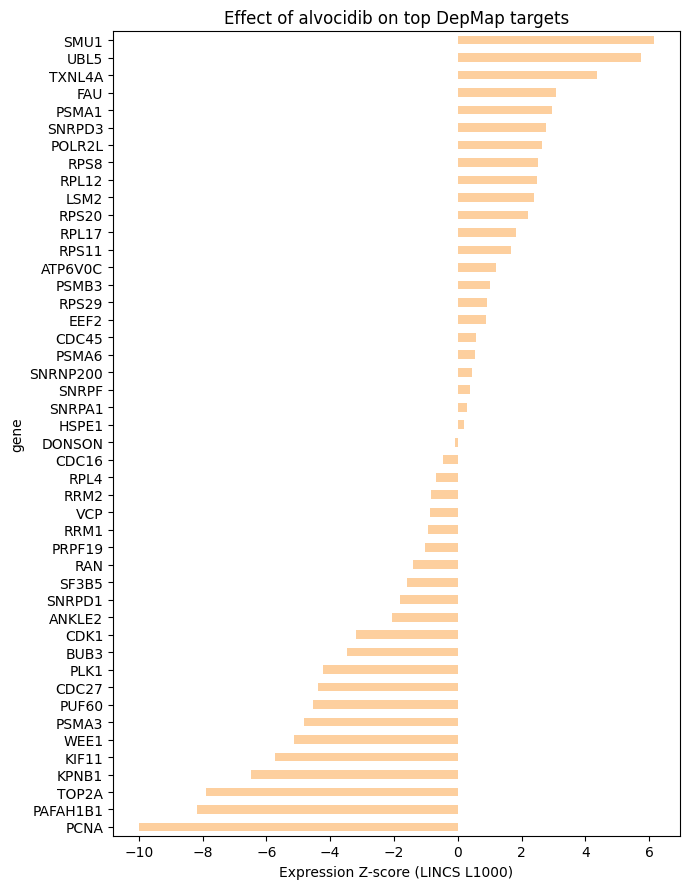

In [34]:
drug_name = "alvocidib"
plt.figure(figsize=(7, 9))
effect_on_targets[drug_name].astype(float).sort_values().plot(
    kind="barh",
    color="#FDCF9E",
    title=f"Effect of {drug_name} on top DepMap targets"
)
plt.xlabel("Expression Z-score (LINCS L1000)")
plt.tight_layout()
plt.show()

**End of the Notebook**